# Get GPU Info

In [ ]:
!nvidia-smi

Mon Jul 12 17:37:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    40W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Installation

In [ ]:
# !pip install -qq transformers
# !pip install -qq transformers[sentencepiece]

# Connecting Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Imports

In [ ]:
# Asthetics
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# General
from scipy.stats import pearsonr, spearmanr, kendalltau
from tqdm.auto import tqdm
from google.colab import files
from bs4 import BeautifulSoup
from shutil import copyfile
import pandas as pd
import numpy as np
import os
import re
import random
import gc
pd.set_option('display.max_columns', None)
np.seterr(divide='ignore', invalid='ignore')
gc.enable()

# Visualizations
from plotly.subplots import make_subplots
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
%matplotlib inline
sns.set(style="whitegrid")

# Machine Leaning
# Utils
from sklearn.model_selection import StratifiedKFold
# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
# NLP
from transformers import AutoTokenizer, AutoModel
#Metrics
from sklearn.metrics import mean_squared_error

# Random Seed Initialize
RANDOM_SEED = 42

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

# Device Optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f'Using device: {device}')

Using device: cuda


# Reading File

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets/CommonLit_NLP/'

train_file_path = os.path.join(data_dir, 'train.csv')
test_file_path = os.path.join(data_dir, 'test.csv')
sample_sub_file_path = os.path.join(data_dir, 'sample_submission.csv')

print(f'Train file: {train_file_path}')
print(f'Test file: {test_file_path}')
print(f'Sample Submission file: {sample_sub_file_path}')

Train file: /content/drive/MyDrive/Colab Notebooks/Datasets/CommonLit_NLP/train.csv
Test file: /content/drive/MyDrive/Colab Notebooks/Datasets/CommonLit_NLP/test.csv
Sample Submission file: /content/drive/MyDrive/Colab Notebooks/Datasets/CommonLit_NLP/sample_submission.csv


In [ ]:
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
sub_df = pd.read_csv(sample_sub_file_path)

In [ ]:
train_df.sample(10)

,id,url_legal,license,excerpt,target,standard_error
2089,b51730f9c,NaN,NaN,"Alice looked at the jury-box, and saw that, in...",-0.432678,0.487498
2806,4d403fd57,https://en.wikipedia.org/wiki/Artificial_intel...,CC BY-SA 3.0,Artificial intelligence (AI) is intelligence e...,-1.161746,0.458396
1146,0f789ee41,NaN,NaN,A gruff squire on horseback with shiny top boo...,-2.367914,0.519369
1110,87f96eb79,NaN,NaN,But that hadn't helped Washington.\nThe Americ...,-0.842596,0.466193
196,b9cca6661,NaN,NaN,The principal business of the people of this c...,-0.748452,0.433000
1837,030b56bc4,NaN,NaN,Since gelatine emulsion first came into use on...,-2.403805,0.475886
322,f1a527e3b,https://en.wikipedia.org/wiki/Databending,CC BY-SA 3.0,Databending (or data bending) is the process o...,-2.524790,0.473425
1613,7257ef363,NaN,NaN,Some improvements have recently been made by M...,-2.246008,0.504454
2251,5e8e57468,NaN,NaN,Among the wonders of San Francisco must be men...,-0.669352,0.474044
2456,398de6619,NaN,NaN,"For August, a salt baker's son and a little co...",-0.938621,0.471399


In [ ]:
test_df.head()

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


# EDA

## Word Count Distribution

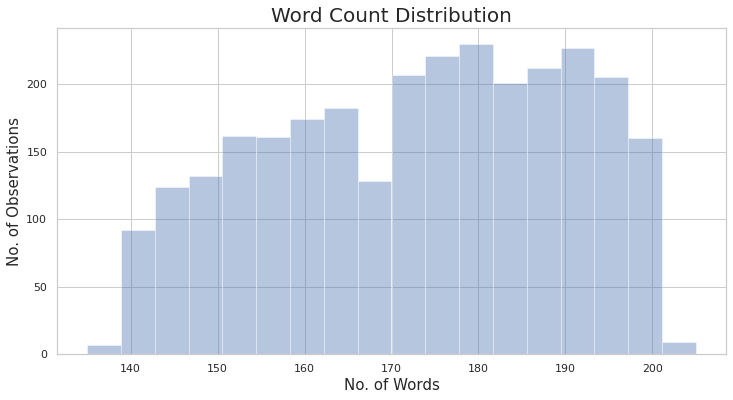

In [ ]:
word_count = [len(x.split()) for x in train_df['excerpt'].tolist()]
barplot_dim = (12, 6)
ax = plt.subplots(figsize =barplot_dim);
ax = sns.distplot(word_count, kde=False);
ax.set_ylabel('No. of Observations', size=15)
ax.set_xlabel('No. of Words', size=15)
ax.set_title('Word Count Distribution', size=20);

Let's see how the word count varies across each range of readability (target):-

In [ ]:
train_df['excerpt_word_count'] = train_df['excerpt'].apply(lambda x: len(x.split()))

pearson_corr, _ = pearsonr(train_df['excerpt_word_count'], train_df['target'])
spearman_corr, _ = spearmanr(train_df['excerpt_word_count'], train_df['target'])
tau_corr, _ = kendalltau(train_df['excerpt_word_count'], train_df['target'])

print('Pearsons correlation: %.3f' % pearson_corr)
print('Spearmans correlation: %.3f' % spearman_corr)
print('Kendall Tau correlation: %.3f' % tau_corr)

Pearsons correlation: -0.124
Spearmans correlation: -0.117
Kendall Tau correlation: -0.079


## Word Count Distribution

In [ ]:
train_df['excerpt_word_count'].describe()

count    2834.000000
mean      172.982004
std        16.974390
min       135.000000
25%       159.000000
50%       175.000000
75%       188.000000
max       205.000000
Name: excerpt_word_count, dtype: float64

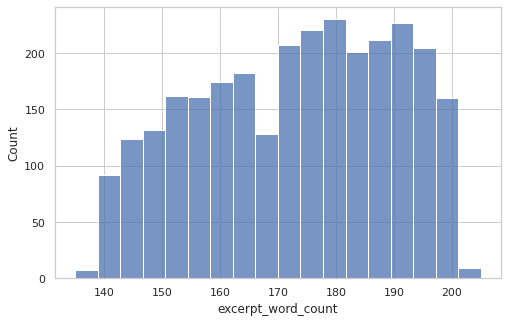

In [ ]:
ax = plt.subplots(figsize=(8, 5))
sns.histplot(data=train_df, x="excerpt_word_count");

## Target Distribution

In [ ]:
train_df['target'].describe()

count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: target, dtype: float64

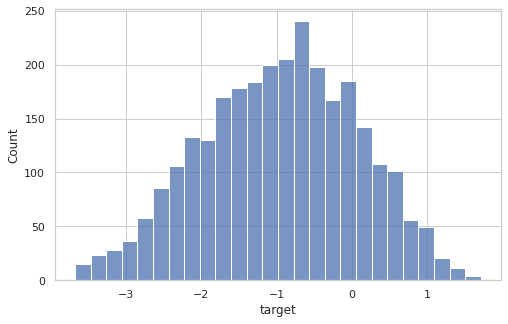

In [ ]:
ax = plt.subplots(figsize=(8, 5))
sns.histplot(data=train_df, x="target");

# Text Cleaning

In [ ]:
def text_cleaning(text):
    '''
    Cleans text into a basic form for NLP. Operations include the following:-
    1. Remove special charecters like &, #, etc
    2. Removes extra spaces
    3. Removes RT in case of Re-Tweets
    4. Removes Numbers
    5. Removes embedded URL links
    6. Removes HTML tags
    7. Removes emojis
    
    text - Text piece to be cleaned.
    '''
    template = re.compile(r'https?://\S+|www\.\S+') #Removes website links
    text = template.sub(r'', text)
    
    soup = BeautifulSoup(text, 'lxml') #Removes HTML tags
    only_text = soup.get_text()
    text = only_text
    
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\d\s]", " ", text) #Remove special Charecters
    text = re.sub(' +', ' ', text) #Remove Extra Spaces
    text = re.sub(r"RT ", " ", text) #Remove RT for Re-tweets
    # text = re.sub(r"[0-9]", " ", text) #Remove Numbers
    text = text.strip() # remove spaces at the beginning and at the end of string

    return text

In [ ]:
tqdm.pandas()
train_df['excerpt'] = train_df['excerpt'].progress_apply(text_cleaning)

In [ ]:
test_df['excerpt'] = test_df['excerpt'].progress_apply(text_cleaning)

In [ ]:
train_df.sample(10)

,id,url_legal,license,excerpt,target,standard_error,excerpt_word_count
1436,4b383dfae,NaN,NaN,when sleeplessness can be directly traced to m...,-2.224235,0.520987,164
748,dfefb0086,https://simple.wikipedia.org/wiki/Sumer,CC BY-SA 3.0 and GFDL,the sumerians made their clothing by using the...,0.294498,0.537551,164
133,df9a91b62,NaN,NaN,life at st austin s was rendered somewhat holl...,-2.457152,0.517299,166
1448,24a74e4fc,NaN,NaN,no doubt much to the disappointment and grief ...,-2.008061,0.458317,182
2544,5cf104360,NaN,NaN,now when blacky the crow discovered that the e...,-0.620987,0.475340,150
944,9707b4ed7,https://www.digitallibrary.io/en/books/details...,CC BY 4.0,we set out in a little boat hoping for a big a...,0.170972,0.490795,155
1595,904f13201,NaN,NaN,he stayed at the station helped in the kitchen...,-0.911057,0.445905,150
1666,d025059c2,NaN,NaN,at first the lizard was freely handled by thos...,-1.660479,0.510179,197
2382,cdea4376d,NaN,NaN,this unlucky nestling had not long sat in this...,-0.820700,0.492485,198
2040,c65dd520d,NaN,NaN,it was on saturday afternoon a week ago he was...,-0.274810,0.511098,163


# CFG

In [ ]:
params = {
    'checkpoint': 'bert-base-cased',
    'output_logits': 768,
    'max_len': 512,
    'num_folds': 5,
    'batch_size': 10,
    'dropout': 0.2,
    'num_workers': 2,
    'epochs': 5,
    'lr': 2e-5,
    'scheduler_name': 'OneCycleLR',
    'max_lr': 5e-5,                 # OneCycleLR
    'pct_start': 0.1,               # OneCycleLR
    'anneal_strategy': 'cos',       # OneCycleLR
    'div_factor': 1e3,              # OneCycleLR
    'final_div_factor': 1e3,        # OneCycleLR
    'no_decay': True,
    'dest': '/content/drive/MyDrive/Colab Notebooks/CLRP_Notebooks/bert_base_cased/'
}

# Dataset

In [ ]:
class BERTDataset:
  def __init__(self, texts, labels, max_len=params['max_len'], checkpoint=params['checkpoint']):
    self.texts = texts
    self.labels = labels
    self.max_len = max_len
    self.checkpoint = checkpoint
    self.tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    self.num_examples = len(self.texts)

  def __len__(self):
    return self.num_examples

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = self.labels[idx]
    tokenized_text = self.tokenizer(
        text,
        add_special_tokens=True,
        truncation=True,
        padding='max_length',
        max_length=self.max_len,
        return_attention_mask=True,
        return_token_type_ids=True,
    )
    ids = tokenized_text['input_ids']
    mask = tokenized_text['attention_mask']
    token_type_ids = tokenized_text['token_type_ids']

    return {'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(label, dtype=torch.float)}

# Scheduler

In [ ]:
def get_scheduler(optimizer, scheduler_params=params):
    if scheduler_params['scheduler_name'] == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer,
            T_0=scheduler_params['T_0'],
            eta_min=scheduler_params['min_lr'],
            last_epoch=-1
        )
    elif scheduler_params['scheduler_name'] == 'OneCycleLR':
        scheduler = OneCycleLR(
            optimizer,
            max_lr=scheduler_params['max_lr'],
            steps_per_epoch=int(df_train.shape[0] / params['batch_size']) + 1,
            epochs=scheduler_params['epochs'],
            pct_start=scheduler_params['pct_start'],
            anneal_strategy=scheduler_params['anneal_strategy'],
            div_factor=scheduler_params['div_factor'],
            final_div_factor=scheduler_params['final_div_factor'],
        )
    return scheduler

# NLP Model

In [ ]:
class CLRPmodel(nn.Module):
  def __init__(self, checkpoint=params['checkpoint'], params=params):
    super(CLRPmodel, self).__init__()
    self.checkpoint = checkpoint
    self.bert = AutoModel.from_pretrained(checkpoint, return_dict=False)
    self.layer_norm = nn.LayerNorm(params['output_logits'])
    self.dropout = nn.Dropout(params['dropout'])
    self.dense = nn.Sequential(
        nn.Linear(params['output_logits'], 512),
        nn.Tanh(),
        nn.Dropout(params['dropout']),
        nn.Linear(512, 1)
    )

  def forward(self, input_ids, token_type_ids, attention_mask):
    _, pooled_output = self.bert(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
    pooled_output = self.layer_norm(pooled_output)
    pooled_output = self.dropout(pooled_output)
    preds = self.dense(pooled_output)
    return preds

# Metrics

In [ ]:
def rmse_score(output, target):
  y_pred = output.cpu()
  y_pred = y_pred.detach().numpy()
  target = target.cpu()
  return mean_squared_error(target, y_pred, squared=False)

# Training And Validation Function

In [ ]:
def train(model, device, train_dataset, valid_dataset, fold, params=params, epochs=params['epochs'], scheduler=params['scheduler_name']):
  model.to(device)
  if params['no_decay']:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = optim.AdamW(optimizer_grouped_parameters, lr=params['lr'])
  else:
    optimizer = optim.AdamW(model.parameters(), lr=params['lr'])
  
  if scheduler is not None:
      scheduler = get_scheduler(optimizer)
  
  criterion = nn.MSELoss()
  best_model_name = None
  best_rmse = np.inf

  for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_rmse = 0
    stream_1 = tqdm(train_dataset)
    stream_1.set_description('Train')
    for batch in stream_1:
      optimizer.zero_grad()
      ids = batch['ids'].to(device)
      mask = batch['mask'].to(device)
      token_type_ids = batch['token_type_ids'].to(device)
      target = batch['target'].to(device)
      logits = model(ids, token_type_ids, mask)
      loss = criterion(logits, target.view(-1, 1))
      rmse = rmse_score(logits, target)
      loss.backward()
      optimizer.step()
      if scheduler is not None:
        scheduler.step()
      train_loss += loss.item() * batch['ids'].size(0)
      train_rmse += rmse
      stream_1.update(1)
    
    train_loss /= len(train_dataset)
    train_rmse /= len(train_dataset)

    model.eval()
    valid_loss = 0
    valid_rmse = 0
    stream_2 = tqdm(valid_dataset)
    stream_2.set_description('Valid')
    for batch in stream_2:
      ids = batch['ids'].to(device)
      mask = batch['mask'].to(device)
      token_type_ids = batch['token_type_ids'].to(device)
      target = batch['target'].to(device)
      logits = model(ids, token_type_ids, mask)
      loss = criterion(logits, target.view(-1, 1))
      rmse = rmse_score(logits, target)
      valid_loss += loss.item() * batch['ids'].size(0)
      valid_rmse += rmse
      stream_2.update(1)

    valid_loss /= len(valid_dataset)
    valid_rmse /= len(valid_dataset)

    print(f"Epoch: {epoch+1:02}/{epochs:02}. Train Loss: {train_loss:.3f}. Validation Loss: {valid_loss:.3f}")
    print(f"Epoch: {epoch+1:02}/{epochs:02}. Train RMSE: {train_rmse:.3f}. Validation RMSE: {valid_rmse:.3f}")

    if valid_rmse < best_rmse:
      best_rmse = valid_rmse
      if best_model_name is not None:
        os.remove(best_model_name)
        os.remove(params['dest']+'/'+best_model_name)
      torch.save(model.state_dict(),
                 f"{params['checkpoint']}_{epoch+1}_epoch_f{fold+1}_{valid_rmse}_rmse.pth")
      best_model_name = f"{params['checkpoint']}_{epoch+1}_epoch_f{fold+1}_{valid_rmse}_rmse.pth"
      copyfile(best_model_name, params['dest']+best_model_name)

# Kfolds

In [ ]:
train_df["kfold"] = -1
train_df = train_df.sample(frac=1).reset_index(drop=True)
num_bins = int(np.floor(1 + np.log2(len(train_df))))
train_df.loc[:, "bins"] = pd.cut(
    train_df["target"], bins=num_bins, labels=False
)
kf = StratifiedKFold(n_splits=params['num_folds'])
for f, (t_, v_) in enumerate(kf.split(X=train_df, y=train_df.bins.values)):
  train_df.loc[v_, 'kfold'] = f
train_df = train_df.drop("bins", axis=1)

train_df.sample(10)

,id,url_legal,license,excerpt,target,standard_error,excerpt_word_count,kfold
2536,f305c0e4a,https://www.africanstorybook.org/,CC BY 4.0,zonke runs home it s quite hot fortunately the...,0.059705,0.470262,199,4
403,ca520088f,NaN,NaN,they rode more briskly through the afternoon a...,-1.480296,0.478385,172,0
2399,2985f4021,https://en.wikipedia.org/wiki/Appropriation_bill,CC BY-SA 3.0,an appropriation bill or running bill or suppl...,-1.752500,0.444110,144,4
1987,93d838248,NaN,NaN,tick tock tick tock said again the old clock a...,0.144415,0.532184,191,3
1213,a9829cf3d,https://simple.wikipedia.org/wiki/State,CC BY-SA 3.0 and GFDL,in modern politics a state is an association w...,-0.881081,0.464852,163,2
1873,c9849a3ad,NaN,NaN,the brain works like a computer with multiple ...,-0.637014,0.474794,138,3
1574,e3b9b8ac4,https://www.africanstorybook.org/#,CC BY 4.0,grandma is coming to visit and always she brin...,-0.194649,0.491303,174,2
44,b51730f9c,NaN,NaN,alice looked at the jury box and saw that in h...,-0.432678,0.487498,168,0
795,31aba067d,https://simple.wikipedia.org/wiki/United_Nations,CC BY-SA 3.0 and GFDL,after world war i the nations of the world for...,-0.124659,0.471840,159,1
741,2b4024021,NaN,NaN,they came to a garden inclosed by a low wall w...,0.090335,0.497793,181,1


# Run 1 fold

In [ ]:
# gc.collect()
# current_fold = 0
# df_train = train_df[train_df['kfold'] != current_fold]
# df_valid = train_df[train_df['kfold'] == current_fold]

In [ ]:
# train_dataset = BERTDataset(
#     df_train.excerpt.values,
#     df_train.target.values
# )
# valid_dataset = BERTDataset(
#     df_valid.excerpt.values,
#     df_valid.target.values
# )

# train_dataloader = DataLoader(
#     train_dataset, batch_size=params['batch_size'], shuffle=True,
#     num_workers=params['num_workers'], pin_memory=True
# )
# valid_dataloader = DataLoader(
#     valid_dataset, batch_size=params['batch_size'], shuffle=False,
#     num_workers=params['num_workers'], pin_memory=True
# )

In [ ]:
# model = CLRPmodel()

In [ ]:
# train(model, device, train_dataloader, valid_dataloader, current_fold)

# Run All Folds

In [ ]:
gc.collect()
for fold in range(params['num_folds']):
  print(f'********************Training Fold: {fold+1}********************')
  current_fold = fold
  df_train = train_df[train_df['kfold'] != current_fold]
  df_valid = train_df[train_df['kfold'] == current_fold]

  train_dataset = BERTDataset(
      df_train.excerpt.values,
      df_train.target.values
  )
  valid_dataset = BERTDataset(
      df_valid.excerpt.values,
      df_valid.target.values
  )

  train_dataloader = DataLoader(
      train_dataset, batch_size=params['batch_size'], shuffle=True,
      num_workers=params['num_workers'], pin_memory=True
  )
  valid_dataloader = DataLoader(
      valid_dataset, batch_size=params['batch_size'], shuffle=False,
      num_workers=params['num_workers'], pin_memory=True
  )
  
  model = CLRPmodel()
  train(model, device, train_dataloader, valid_dataloader, fold)
  del model
  gc.collect()

********************Training Fold: 1********************


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Epoch: 01/05. Train Loss: 7.834. Validation Loss: 4.406
Epoch: 01/05. Train RMSE: 0.847. Validation RMSE: 0.649



Epoch: 02/05. Train Loss: 3.959. Validation Loss: 3.306
Epoch: 02/05. Train RMSE: 0.610. Validation RMSE: 0.566



Epoch: 03/05. Train Loss: 2.162. Validation Loss: 2.833
Epoch: 03/05. Train RMSE: 0.453. Validation RMSE: 0.520



Epoch: 04/05. Train Loss: 1.291. Validation Loss: 3.572
Epoch: 04/05. Train RMSE: 0.348. Validation RMSE: 0.585



Epoch: 05/05. Train Loss: 0.937. Validation Loss: 3.131
Epoch: 05/05. Train RMSE: 0.296. Validation RMSE: 0.547
********************Training Fold: 2********************


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Epoch: 01/05. Train Loss: 8.329. Validation Loss: 6.848
Epoch: 01/05. Train RMSE: 0.868. Validation RMSE: 0.816



Epoch: 02/05. Train Loss: 3.495. Validation Loss: 3.458
Epoch: 02/05. Train RMSE: 0.575. Validation RMSE: 0.578



Epoch: 03/05. Train Loss: 1.859. Validation Loss: 3.579
Epoch: 03/05. Train RMSE: 0.418. Validation RMSE: 0.588



Epoch: 04/05. Train Loss: 1.108. Validation Loss: 3.437
Epoch: 04/05. Train RMSE: 0.325. Validation RMSE: 0.576



Epoch: 05/05. Train Loss: 0.756. Validation Loss: 3.428
Epoch: 05/05. Train RMSE: 0.268. Validation RMSE: 0.575
********************Training Fold: 3********************


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Epoch: 01/05. Train Loss: 7.195. Validation Loss: 3.688
Epoch: 01/05. Train RMSE: 0.810. Validation RMSE: 0.594



Epoch: 02/05. Train Loss: 3.233. Validation Loss: 3.360
Epoch: 02/05. Train RMSE: 0.553. Validation RMSE: 0.566



Epoch: 03/05. Train Loss: 1.935. Validation Loss: 3.135
Epoch: 03/05. Train RMSE: 0.426. Validation RMSE: 0.546



Epoch: 04/05. Train Loss: 1.160. Validation Loss: 3.346
Epoch: 04/05. Train RMSE: 0.332. Validation RMSE: 0.564



Epoch: 05/05. Train Loss: 0.767. Validation Loss: 3.288
Epoch: 05/05. Train RMSE: 0.269. Validation RMSE: 0.559
********************Training Fold: 4********************


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Epoch: 01/05. Train Loss: 11.309. Validation Loss: 10.896
Epoch: 01/05. Train RMSE: 1.026. Validation RMSE: 1.029



Epoch: 02/05. Train Loss: 11.439. Validation Loss: 10.594
Epoch: 02/05. Train RMSE: 1.043. Validation RMSE: 1.014



Epoch: 03/05. Train Loss: 10.080. Validation Loss: 7.044
Epoch: 03/05. Train RMSE: 0.979. Validation RMSE: 0.820



Epoch: 04/05. Train Loss: 5.213. Validation Loss: 4.455
Epoch: 04/05. Train RMSE: 0.702. Validation RMSE: 0.655



Epoch: 05/05. Train Loss: 3.716. Validation Loss: 4.246
Epoch: 05/05. Train RMSE: 0.594. Validation RMSE: 0.636
********************Training Fold: 5********************


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Epoch: 01/05. Train Loss: 8.447. Validation Loss: 4.524
Epoch: 01/05. Train RMSE: 0.862. Validation RMSE: 0.657



Epoch: 02/05. Train Loss: 4.220. Validation Loss: 6.207
Epoch: 02/05. Train RMSE: 0.632. Validation RMSE: 0.774



Epoch: 03/05. Train Loss: 2.297. Validation Loss: 4.111
Epoch: 03/05. Train RMSE: 0.466. Validation RMSE: 0.625



Epoch: 04/05. Train Loss: 1.297. Validation Loss: 3.171
Epoch: 04/05. Train RMSE: 0.349. Validation RMSE: 0.550



Epoch: 05/05. Train Loss: 0.951. Validation Loss: 3.238
Epoch: 05/05. Train RMSE: 0.300. Validation RMSE: 0.556
